In [ ]:
# https://stackoverflow.com/questions/48641189/fitting-3d-data-as-input-into-keras-sequential-model-layer

In [ ]:
!pip install qhoptim
!conda install keras=2.3.1 -y

In [2]:
# Use only CPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [2]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc

#keras
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, AveragePooling1D, GlobalAveragePooling1D

from tensorflow.keras.layers import Conv2D, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle5 as pickle
# 
# from qhoptim.tf import QHAdamOptimizer

In [3]:
# small old ../datasets/AMPsNonAMPs_df.239.plk
# /home/ubuntu/data/AMPsNonAMPs_df.plk old dataset
# /mnt/vdb/thesis/jax/AMPNonAMP.final.reps new dataset

with open( "/mnt/vdb/thesis/jax/AMPNonAMP.V5_C08_sim60.reps", 'rb') as file:
    AMPs_df = pickle.load(file)

In [2]:
# For PWS
with open( '/mnt/vdb/thesis/pwm/AMPnonAMP.sim60_c08.pssm.pkl', 'rb') as file:
    AMPs_df = pickle.load(file)


In [ ]:
#AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df =AMPs_df[AMPs_df["length"] <=30 ]
AMPs_df 

### Utility function: plot_history, display_model_score

In [3]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

def create_roc_curve(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)  

    plt.title('Receiver Operating Characteristic' )
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)

    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.show()

# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    auc_score = auc(recall, precision)
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    pyplot.title('2-class Precision-Recall curve')
    # plot the no skill precision-recall curve
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precis|ion-recall curve
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    pyplot.plot(recall, precision, marker='.', label='Model AUC = %0.2f'% auc_score)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test = None):
  train_score = model.evaluate(train[0], train[1], verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  if test != None:
      test_score = model.evaluate(test[0], test[1], verbose=1)
      print('Test loss: ', test_score[0])
      print('Test accuracy: ', test_score[1])

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

In [4]:
#from keras import backend as K
#K.set_value(model_ProtCNN.optimizer.learning_rate, 0.00001)
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 80:
        lr = 0.1e-6
    elif epoch > 50:    
        lr = 0.3e-5
    elif epoch > 20:
        lr = 1e-4
        
    # print(' Learning rate: ', lr)    
    return lr 

# Split Train/ Test / Validation set

In [4]:
AMPs_df.shape

(137389, 400)

In [15]:
#X= np.array(AMPs_df['reps'].to_list())
#y= np.array(AMPs_df['class'].to_list())

X_train, X_test, y_train, y_test = train_test_split(np.array(AMPs_df['reps'].to_list()),  np.array(AMPs_df['class'].to_list()), test_size=0.2, random_state=1,shuffle =True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,shuffle =True) # 0.25 x 0.8 = 0.2

In [16]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  51873
Val size:  17292
Test size:  17292


## Custom CNN

In [17]:
# 3d dimension for LSTM
# Batchs, n_timesteps, n_features

# Images 3d dimension
# width , heigth , channel

# Conv1D with sequential data
# batch, steps, channels

# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(51873, 400, 1)
(17292, 400, 1)
(17292, 400, 1)


In [7]:
X_train

array([[[ 0.05368484, -0.03313179, -0.04137151, ...,  0.04686536,
          0.07515805,  0.09453979]],

       [[ 0.01226678,  0.03930363,  0.02485003, ...,  0.03290013,
          0.0553586 , -0.03752161]],

       [[ 0.02220141, -0.0530687 ,  0.0117378 , ...,  0.06830079,
          0.13145781,  0.03153091]],

       ...,

       [[ 0.01613748,  0.0919472 ,  0.07108982, ...,  0.05503492,
         -0.02092175,  0.02752282]],

       [[ 0.00737427, -0.02503035,  0.03058322, ..., -0.04634462,
          0.13963404,  0.00552622]],

       [[ 0.01309069,  0.00857742,  0.03156777, ...,  0.05718511,
          0.09086805, -0.00191969]]])

In [13]:
X_train.shape[1]

1

In [12]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

ValueError: cannot reshape array of size 156622700 into shape (82433,1,1)

In [7]:
# the best Mark I
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    conv = Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=2)(conv)

    # Flatten NN
    flat = Flatten()(conv)
    
    layer_3 = Dense(2432, activation='relu')(flat)
    dropout_3 = Dropout(0.5)(layer_3)
    layer_4 = Dense(1211, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.5)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="RMSprop", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 512)         4096      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 633, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 633, 256)          655616    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 316, 256)          0         
_________________________________________________________________
flatten (Flatten)            (None, 80896)             0         
_________________________________________________________________
dense (Dense)                (None, 1211)             

In [58]:
# n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], 1
# nn.Conv1d with a kernel size of 1 and nn.Linear   give exactly the same results.

# use in dev 

#SGD
#RMSprop
#Adam
#Adadelta
#Adagrad
#Adamax
#Nadam
#Ftrl
#
#
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
    #conv = Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu')(x_input) 
    #conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(512, kernel_size=8, strides=1, padding='same', activation='relu')(x_input) 
    conv = MaxPooling1D(pool_size=3)(conv)
    dropout_3 = Dropout(0.5)(layer_3)
    conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(conv) 
    conv = MaxPooling1D(pool_size=2)(conv)
    dropout_3 = Dropout(0.5)(layer_3)
   
    # Flatten NN
    flat = Flatten()(conv)
    layer_3 = Dense(1211, activation='relu')(flat)
    dropout_3 = Dropout(0.2)(layer_3)
    layer_4 = Dense(1211, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.2)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l2(0.0001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1900, 512)         4608      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 633, 512)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 633, 256)          655616    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 316, 256)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 80896)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1211)            

In [19]:
# create_ModelII
## https://github.com/p-koo/learning_sequence_motifs/blob/master/code/models/cnn_25.py show best here 
def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    # Conv
  #bn1 = BatchNormalization()(data)
  #act1 = Activation('relu')(bn1)
    
    conv = Conv1D(128, kernel_size=19, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)
    
    x = BatchNormalization()(conv)
   
    # Flatten NN
    flat = Flatten()(x)
    layer_3 = Dense(1211, activation='relu')(flat)
    dropout_3 = Dropout(0.5)(layer_3)
    layer_4 = Dense(512, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.5)(layer_4)
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(dropout_4)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1900, 128)         2560      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 76, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 76, 128)           82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 19, 128)           512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2432)             

In [ ]:
# https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras

In [8]:
# create_ModelIIII
#

def create_Modelbaseline():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
        
    conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)
    
    x = BatchNormalization()(conv)
    x = Flatten()(x)
    #output = GlobalMaxPooling1D()(x)
    
    output = Dense(2432, activation=None)(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    output = Dense(1216, activation=None)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(output)
    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 64)          2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 76, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 128)           57472     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 128)           512       
_________________________________________________________________
flatten (Flatten)            (None, 2432)             

In [21]:
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/CustomCNN.Adam.v4.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(X_train, y_train, epochs=100,
                    batch_size=128, validation_data=(X_val, y_val),
                    callbacks=[es, lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
645/645 [==============================] - 8s 13ms/step - loss: 0.3627 - accuracy: 0.8438 - val_loss: 0.4580 - val_accuracy: 0.7969
 Learning rate:  0.001
Epoch 2/100
645/645 [==============================] - 8s 12ms/step - loss: 0.2875 - accuracy: 0.8804 - val_loss: 0.3460 - val_accuracy: 0.8559
 Learning rate:  0.001
Epoch 3/100
645/645 [==============================] - 8s 12ms/step - loss: 0.2612 - accuracy: 0.8932 - val_loss: 0.3036 - val_accuracy: 0.8721
 Learning rate:  0.001
Epoch 4/100
645/645 [==============================] - 7s 12ms/step - loss: 0.2425 - accuracy: 0.9011 - val_loss: 0.2612 - val_accuracy: 0.8937
 Learning rate:  0.001
Epoch 5/100
645/645 [==============================] - 8s 12ms/step - loss: 0.2296 - accuracy: 0.9075 - val_loss: 0.3445 - val_accuracy: 0.8735
 Learning rate:  0.001
Epoch 6/100
645/645 [==============================] - 8s 12ms/step - loss: 0.2215 - accuracy: 0.9099 - val_loss: 0.2718 - val_accuracy: 0.892

In [25]:
model.save('/mnt/vdb/thesis/CustomCNN.Adam.III.V5.h5') 

In [22]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

2577/2577 [==============================] - 6s 2ms/step - loss: 0.0143 - accuracy: 0.9968
Train loss:  0.014292317442595959
Train accuracy:  0.9968095421791077
----------------------------------------------------------------------
859/859 [==============================] - 2s 2ms/step - loss: 0.3717 - accuracy: 0.9305
Val loss:  0.3716603219509125
Val accuracy:  0.9305262565612793
----------------------------------------------------------------------
859/859 [==============================] - 2s 2ms/step - loss: 0.4053 - accuracy: 0.9254
Test loss:  0.40525904297828674
Test accuracy:  0.9253948330879211


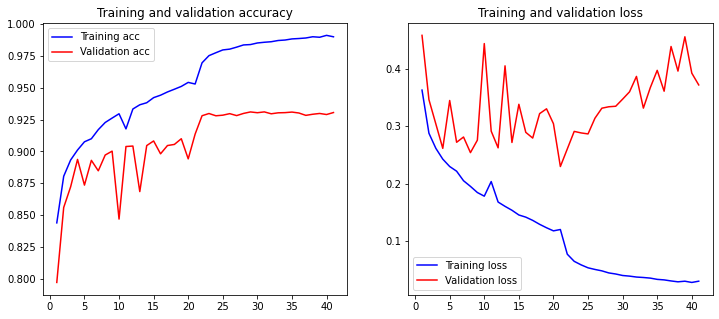

In [23]:
plot_history(history)

In [24]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     13856
           1       0.92      0.93      0.92     13622

    accuracy                           0.93     27478
   macro avg       0.93      0.93      0.93     27478
weighted avg       0.93      0.93      0.93     27478



In [12]:
# Markk III
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     21596
           1       0.94      0.95      0.95     21260

    accuracy                           0.95     42856
   macro avg       0.95      0.95      0.95     42856
weighted avg       0.95      0.95      0.95     42856



In [ ]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

In [20]:
# 11/3/2021
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     22886
           1       0.95      0.91      0.93     22400

    accuracy                           0.93     45286
   macro avg       0.94      0.93      0.93     45286
weighted avg       0.93      0.93      0.93     45286



In [62]:
# the best
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     25564
           1       0.96      0.95      0.95     25244

    accuracy                           0.95     50808
   macro avg       0.95      0.95      0.95     50808
weighted avg       0.95      0.95      0.95     50808



# PWM 

## 1D COV

In [5]:
# For 400 dimension
Y1 =np.array([0] * 68869 + [1] * 68520)
X_train, X_test, y_train, y_test = train_test_split(AMPs_df, Y1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [18]:
def create_Modelbaseline():
    x_input = Input(shape=(400,1)) # n_timesteps, n_features
        
    conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)
    
    x = BatchNormalization()(conv)
    x = Flatten()(x)
    #output = GlobalMaxPooling1D()(x)
    
    output = Dense(2432, activation=None)(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    output = Dense(1216, activation=None)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(output)
    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 400, 64)           2624      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 128)           57472     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 128)            512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)              

In [20]:

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

## balance data
history = model.fit(X_train, y_train, epochs=100,
                    batch_size=128, validation_data=(X_val, y_val),
                    callbacks=[es, lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
406/406 [==============================] - 2s 5ms/step - loss: 0.5011 - accuracy: 0.7619 - val_loss: 7.2520 - val_accuracy: 0.4977
 Learning rate:  0.001
Epoch 2/100
406/406 [==============================] - 2s 5ms/step - loss: 0.4400 - accuracy: 0.7935 - val_loss: 101.3334 - val_accuracy: 0.4977
 Learning rate:  0.001
Epoch 3/100
406/406 [==============================] - 2s 5ms/step - loss: 0.4240 - accuracy: 0.8018 - val_loss: 9.9513 - val_accuracy: 0.4977
 Learning rate:  0.001
Epoch 4/100
406/406 [==============================] - 2s 5ms/step - loss: 0.4123 - accuracy: 0.8100 - val_loss: 8.3450 - val_accuracy: 0.5023
 Learning rate:  0.001
Epoch 5/100
406/406 [==============================] - 2s 5ms/step - loss: 0.4152 - accuracy: 0.8065 - val_loss: 23.2572 - val_accuracy: 0.4977
 Learning rate:  0.001
Epoch 6/100
406/406 [==============================] - 2s 5ms/step - loss: 0.4029 - accuracy: 0.8137 - val_loss: 20.0470 - val_accuracy: 0.4977


In [21]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])
# the best
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

1622/1622 [==============================] - 3s 2ms/step - loss: 13.9586 - accuracy: 0.4991
Train loss:  13.95862102508545
Train accuracy:  0.49906501173973083
----------------------------------------------------------------------
541/541 [==============================] - 1s 2ms/step - loss: 13.9938 - accuracy: 0.4977
Val loss:  13.993794441223145
Val accuracy:  0.497744619846344
----------------------------------------------------------------------
541/541 [==============================] - 1s 2ms/step - loss: 13.8105 - accuracy: 0.5046
Test loss:  13.810529708862305
Test accuracy:  0.5046263933181763
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      8726
           1       0.00      0.00      0.00      8566

    accuracy                           0.50     17292
   macro avg       0.25      0.50      0.34     17292
weighted avg       0.25      0.50      0.34     17292



/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


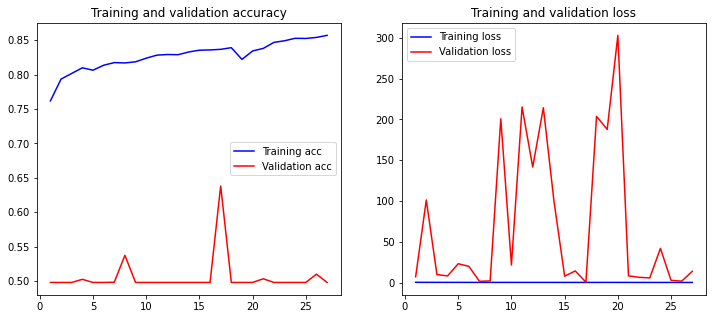

In [22]:
plot_history(history)

In [11]:
model.save('/mnt/vdb/thesis/CustomCNN.Adam.V6.set_9.h5')

## 2D Conv

In [52]:
# For PWM -400 dimension
window_sizes = 20

X = AMPs_df[:,0:window_sizes*20].reshape(len(AMPs_df),1,20,window_sizes)
Y = np.array([0] * 68869 + [1] * 68520) # <-- change here
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
# https://github.com/khanhlee/snare-cnn/blob/master/snare_classification.py

num_features = 400
nb_classes = 2
nb_kernels = 3
nb_pools = 2

def cnn_model():
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1), input_shape = (1,20,window_sizes)))
    model.add(Conv2D(32, (nb_kernels, nb_kernels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pools, nb_pools), data_format="channels_first"))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (nb_kernels, nb_kernels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pools, nb_pools), data_format="channels_first"))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (nb_kernels, nb_kernels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pools, nb_pools), data_format="channels_first"))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (nb_kernels, nb_kernels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pools, nb_pools), data_format="channels_first"))

    #model.add(Conv2D(32, (nb_kernels, nb_kernels), padding="same", input_shape=(1,20,window_sizes)))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(strides=(nb_pools, nb_pools), data_format="channels_first"))
    
    #model.add(Conv2D(64, (nb_kernels, nb_kernels), padding="same" ))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(strides=(nb_pools, nb_pools), data_format="channels_first"))
    
    #model.add(Conv2D(128, (nb_kernels, nb_kernels), padding="same"))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(strides=(nb_pools, nb_pools), data_format="channels_first"))

    #model.add(Conv2D(256, (nb_kernels, nb_kernels), padding="same"))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(strides=(nb_pools, nb_pools), data_format="channels_first"))

    ## add the model on top of the convolutional base
    #model.add(top_model)
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(256))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))

    model.add(  Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001)))
    #model.add(BatchNormalization())

    # f = open('model_summary.txt','w')
    # f.write(str(model.summary()))
    # f.close()

    #model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = cnn_model()
#model.summary()

In [95]:
# Mark III
def create_Modelbaseline():
    x_input = Input(shape=(1,20,window_sizes)) # n_timesteps, n_features
        
    conv = Conv2D(64, kernel_size=(5,5), strides=(1,1) , padding='same', activation='relu', data_format="channels_first")(x_input)  # Extract whole motif pattern
    conv = MaxPooling2D(pool_size=(2,2), strides=(1,1) , data_format="channels_first") (conv)
    conv = Conv2D(128, kernel_size=(3,3), strides=(1,1)  , padding='same', activation='relu', data_format="channels_first")(conv)  # Extract extra features  
    conv = MaxPooling2D(pool_size=(2,2) , strides=(1,1)  , data_format="channels_first")(conv)
    
    x = BatchNormalization()(conv)
    x = Flatten()(x)
    #output = GlobalMaxPooling1D()(x)
    
    output = Dense(1000, activation=None)(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    output = Dense(512, activation=None)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(output)
    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = create_Modelbaseline()
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 20, 20)]       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 64, 20, 20)        1664      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 64, 19, 19)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 128, 19, 19)       73856     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 128, 18, 18)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 18, 18)       72        
_________________________________________________________________
flatten_18 (Flatten)         (None, 41472)            

In [96]:

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

## balance data
history = model.fit(X_train, y_train, epochs=100,
                    batch_size=128, validation_data=(X_val, y_val),
                    callbacks=[es, lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
645/645 [==============================] - 7s 11ms/step - loss: 0.5055 - accuracy: 0.7669 - val_loss: 0.4115 - val_accuracy: 0.8144
 Learning rate:  0.001
Epoch 2/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3977 - accuracy: 0.8252 - val_loss: 0.3720 - val_accuracy: 0.8417
 Learning rate:  0.001
Epoch 3/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3623 - accuracy: 0.8447 - val_loss: 0.3477 - val_accuracy: 0.8500
 Learning rate:  0.001
Epoch 4/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3407 - accuracy: 0.8551 - val_loss: 0.3420 - val_accuracy: 0.8538
 Learning rate:  0.001
Epoch 5/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3223 - accuracy: 0.8652 - val_loss: 0.3201 - val_accuracy: 0.8641
 Learning rate:  0.001
Epoch 6/100
645/645 [==============================] - 7s 11ms/step - loss: 0.3057 - accuracy: 0.8727 - val_loss: 0.3111 - val_accuracy: 0.872

In [97]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

2577/2577 [==============================] - 5s 2ms/step - loss: 0.0524 - accuracy: 0.9843
Train loss:  0.052420176565647125
Train accuracy:  0.9843388199806213
----------------------------------------------------------------------
859/859 [==============================] - 2s 2ms/step - loss: 0.3067 - accuracy: 0.9069
Val loss:  0.3066624402999878
Val accuracy:  0.906907320022583
----------------------------------------------------------------------
859/859 [==============================] - 2s 2ms/step - loss: 0.3040 - accuracy: 0.9078
Test loss:  0.3039868474006653
Test accuracy:  0.9077807664871216


In [98]:
# the best
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     13820
           1       0.90      0.92      0.91     13658

    accuracy                           0.91     27478
   macro avg       0.91      0.91      0.91     27478
weighted avg       0.91      0.91      0.91     27478



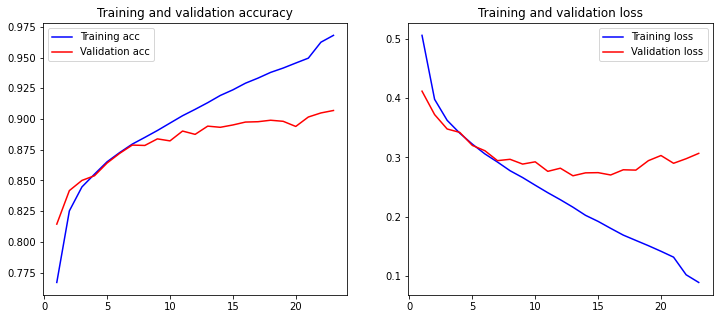

In [99]:
plot_history(history)

In [25]:
model.save('/mnt/vdb/thesis/CustomCNN.Adam.V6.h5')

## Training set2

In [46]:
import pickle5 as pickle
with open( "/mnt/vdb/thesis/trainingset2/set9/jax/AMPNonAMP.reps", 'rb') as file:
    AMPNonAMP_df = pickle.load(file)
with open( "/mnt/vdb/thesis/trainingset2/benchmark_set/jax/AMPNonAMP.benchmark_set.reps", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_train = np.array(AMPNonAMP_df['reps'].to_list())
y_train = np.array(AMPNonAMP_df['class'].to_list())
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(56611, 1900, 1)
(3556, 1900, 1)
(14153, 1900, 1)


In [51]:
with open( "/mnt/vdb/thesis/trainingset2/set9/pssm/AMP/AMP.pssm.plk", 'rb') as file:
    AMPs_df = pickle.load(file)
AMPs_df["class"] = 0
with open( "/mnt/vdb/thesis/trainingset2/set9/pssm/nonAMP/nonAMP.pssm.plk", 'rb') as file:
    nonAMPs_df = pickle.load(file)   
nonAMPs_df["class"] = 1

AMPNonAMP_df = pd.concat([AMPs_df, nonAMPs_df], ignore_index=True)

#AMPs_df = AMPs_df[AMPs_df["length"] <= 300 ]
with open( "../datasets/thesis/trainingset2/benchmark_set/AMPnonAMP.pssm.pkl", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_train = np.array(AMPNonAMP_df['reps'].to_list())
y_train = np.array(AMPNonAMP_df['class'].to_list())
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(56620, 400, 1)
(3556, 400, 1)
(14155, 400, 1)


In [ ]:
    conv = Conv1D(64, kernel_size=7, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=2)(conv)

In [35]:
def create_Modelbaseline_jax():
    x_input = Input(shape=(1900,1)) # n_timesteps, n_features
        
    conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)
    
    x = BatchNormalization()(conv)
    x = Flatten()(x)
    #output = GlobalMaxPooling1D()(x)
    
    output = Dense(1211, activation=None)(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    output = Dense(1211, activation=None)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(output)
    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def create_Modelbaseline():
    #x_input = Input(shape=(1900,1)) # n_timesteps, n_features
    x_input = Input(shape=(400,1))    
    conv = Conv1D(64, kernel_size=7, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=2)(conv)
    
    x = BatchNormalization()(conv)
    x = Flatten()(x)
    #output = GlobalMaxPooling1D()(x)
    
    output = Dense(1211, activation=None)(x)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    output = Dense(1211, activation=None)(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)
    
    x_output = Dense(1, activation='sigmoid', name='output_layer', kernel_regularizer=l1_l2(0.000001))(output)
    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

#model = create_Modelbaseline()
#model.summary()

In [37]:
model = create_Modelbaseline_jax()
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

## balance data
history = model.fit(X_train, y_train, epochs=100,
                    batch_size=128, validation_data=(X_val, y_val),
                    callbacks=[es, lr_scheduler], verbose=1)

Epoch 1/100
443/443 [==============================] - 4s 9ms/step - loss: 0.3784 - accuracy: 0.8441 - val_loss: 0.4777 - val_accuracy: 0.8401
Epoch 2/100
443/443 [==============================] - 4s 8ms/step - loss: 0.3082 - accuracy: 0.8697 - val_loss: 0.3650 - val_accuracy: 0.8174
Epoch 3/100
443/443 [==============================] - 4s 8ms/step - loss: 0.2902 - accuracy: 0.8782 - val_loss: 0.3368 - val_accuracy: 0.8574
Epoch 4/100
443/443 [==============================] - 4s 8ms/step - loss: 0.2796 - accuracy: 0.8829 - val_loss: 0.6603 - val_accuracy: 0.7610
Epoch 5/100
443/443 [==============================] - 4s 8ms/step - loss: 0.2691 - accuracy: 0.8878 - val_loss: 0.4990 - val_accuracy: 0.7989
Epoch 6/100
443/443 [==============================] - 4s 8ms/step - loss: 0.2589 - accuracy: 0.8928 - val_loss: 0.3741 - val_accuracy: 0.8289
Epoch 7/100
443/443 [==============================] - 4s 8ms/step - loss: 0.2547 - accuracy: 0.8947 - val_loss: 0.3345 - val_accuracy: 0.8501

## JAX -Result

In [38]:
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85      1778
           1       0.94      0.71      0.81      1778

    accuracy                           0.83      3556
   macro avg       0.85      0.83      0.83      3556
weighted avg       0.85      0.83      0.83      3556



In [22]:
# the best
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1778
           1       0.87      0.80      0.84      1778

    accuracy                           0.84      3556
   macro avg       0.85      0.84      0.84      3556
weighted avg       0.85      0.84      0.84      3556



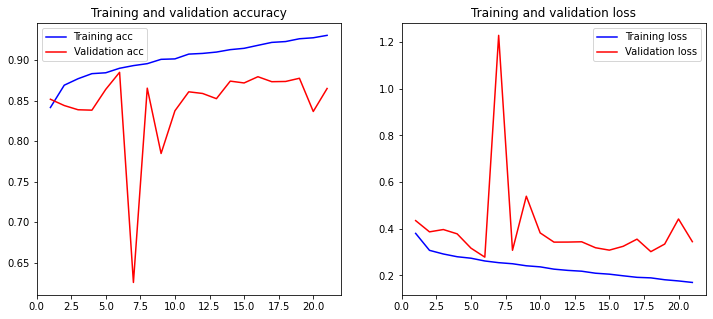

In [23]:
plot_history(history)

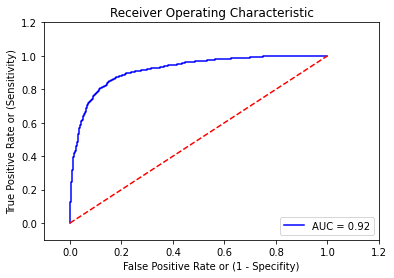

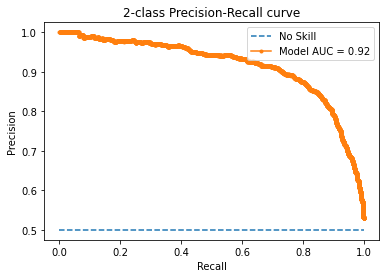

In [24]:
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)

In [52]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

In [50]:

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
_precision = []
_recal = []
_f1 = []
_auc_pr = []
_roc_pr = []
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index  in kfold.split(inputs, targets):
    
    X_train= inputs[train_index]
    y_train= targets[train_index]
    X_val=  inputs[test_index]
    y_val = targets[test_index]
    # Early Stopping
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    #learning rate decay
    lr_scheduler = LearningRateScheduler(lr_schedule)
    model = create_Modelbaseline_jax()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train, y_train, epochs=100,batch_size=128,
                        validation_data=(X_val, y_val),
                        callbacks=[es, lr_scheduler], verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    # predict probabilities for test set
    y_probas = model.predict(X_test)
    threshold = 0.5
    y_predict = np.where(y_probas > threshold, 1, 0)

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_predict, y_test)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = (precision_score(y_predict,y_test, pos_label= 1)+precision_score(y_predict,y_test , pos_label= 0))*0.5
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = (recall_score(y_predict,y_test, pos_label= 1)+recall_score(y_predict,y_test , pos_label= 0))*0.5
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 =  (f1_score(y_predict,y_test, pos_label= 1)+f1_score(y_predict,y_test , pos_label= 0))*0.5
    print('F1 score: %f' % f1)
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])  
    _precision.append(precision * 100)  
    _recal.append(recall * 100)  
    _f1.append(f1 * 100)  
 
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Pecision: {np.mean(_precision)} (+- {np.std(_precision)})')
print(f'> Recall: {np.mean(_recal)} (+- {np.std(_recal)})')
print(f'> F1: {np.mean(_f1)} (+- {np.std(_f1)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 00022: early stopping
Score for fold 1: loss of 0.41078993678092957; accuracy of 83.77390503883362%
Accuracy: 0.837739
Precision: 0.837739
Recall: 0.856805
F1 score: 0.835542
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 00032: early stopping
Score for fold 2: loss of 0.49693983793258667; accuracy of 83.01462531089783%
Accuracy: 0.830146
Precision: 0.830146
Recall: 0.852742
F1 score: 0.827382
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 00034: early stopping
Score for fold 3: loss of 0.5766687989234924; accuracy of 81.72103762626648%
Accuracy: 0.817210
Precision: 0.817210
Recall: 0.844214
F1 score: 0.813554
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 00023: early stopping
Score for fold 4: loss of 0.47706183791160

## PSSM Result

In [29]:
# the best
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.52      0.95      0.67      1778
           1       0.71      0.11      0.20      1778

    accuracy                           0.53      3556
   macro avg       0.61      0.53      0.43      3556
weighted avg       0.61      0.53      0.43      3556



In [34]:
# the best
y_probas = model.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.56      0.93      0.70      1778
           1       0.80      0.28      0.41      1778

    accuracy                           0.60      3556
   macro avg       0.68      0.60      0.56      3556
weighted avg       0.68      0.60      0.56      3556



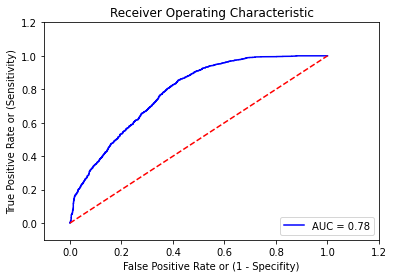

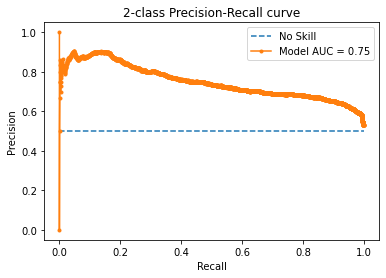

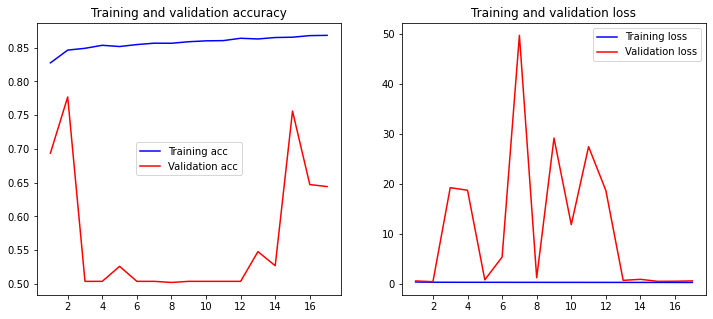

In [36]:
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)
plot_history(history)

In [38]:
score = model.evaluate(X_test, y_test, verbose=0)

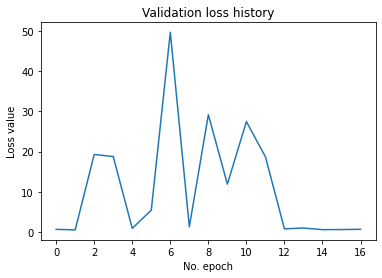

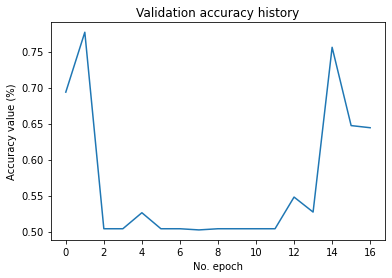

In [40]:

# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [54]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
_precision = []
_recal = []
_f1 = []
_auc_pr = []
_roc_pr = []
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index  in kfold.split(inputs, targets):
    
    X_train= inputs[train_index]
    y_train= targets[train_index]
    X_val=  inputs[test_index]
    y_val = targets[test_index]
    # Early Stopping
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    #learning rate decay
    lr_scheduler = LearningRateScheduler(lr_schedule)
    model = create_Modelbaseline()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train, y_train, epochs=100,batch_size=128,
                        validation_data=(X_val, y_val),
                        callbacks=[es, lr_scheduler], verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    # predict probabilities for test set
    y_probas = model.predict(X_test)
    threshold = 0.5
    y_predict = np.where(y_probas > threshold, 1, 0)

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_predict, y_test)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = (precision_score(y_predict,y_test, pos_label= 1)+precision_score(y_predict,y_test , pos_label= 0))*0.5
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = (recall_score(y_predict,y_test, pos_label= 1)+recall_score(y_predict,y_test , pos_label= 0))*0.5
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 =  (f1_score(y_predict,y_test, pos_label= 1)+f1_score(y_predict,y_test , pos_label= 0))*0.5
    print('F1 score: %f' % f1)
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])  
    _precision.append(precision * 100)  
    _recal.append(recall * 100)  
    _f1.append(f1 * 100)  
 
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Pecision: {np.mean(_precision)} (+- {np.std(_precision)})')
print(f'> Recall: {np.mean(_recal)} (+- {np.std(_recal)})')
print(f'> F1: {np.mean(_f1)} (+- {np.std(_f1)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 00048: early stopping
Score for fold 1: loss of 0.48726919293403625; accuracy of 77.3059606552124%
Accuracy: 0.773060
Precision: 0.773060
Recall: 0.773448
F1 score: 0.772979
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 00051: early stopping
Score for fold 2: loss of 0.6429330110549927; accuracy of 67.04161763191223%
Accuracy: 0.670416
Precision: 0.670416
Recall: 0.721834
F1 score: 0.650143
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.4136185050010681; accuracy of 82.05849528312683%
Accuracy: 0.820585
Precision: 0.820585
Recall: 0.821268
F1 score: 0.820489
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 00017: early stopping
Score for fold 4: loss of 38.083770751953125; accuracy of 50.0%
Accuracy

/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------------------------------------------------------
Training for fold 5 ...
Epoch 00024: early stopping
Score for fold 5: loss of 0.6389148235321045; accuracy of 68.70078444480896%
Accuracy: 0.687008
Precision: 0.687008
Recall: 0.742579
F1 score: 0.667993
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.48726919293403625 - Accuracy: 77.3059606552124%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6429330110549927 - Accuracy: 67.04161763191223%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.4136185050010681 - Accuracy: 82.05849528312683%
------------------------------------------------------------------------
> Fold 4 - Loss: 38.083770751953125 - Accuracy: 50.0%
------------------------------------------------------------------------
> Fold 5 - Loss

In [56]:
model.save('/mnt/vdb/thesis/CustomCNN.Adam.V6.set_9.pssm.h5')

## CNN 2D images

In [5]:
from  tensorflow.keras.preprocessing.image import ImageDataGenerator

In [64]:
# check image 
# example of pixel normalization
from numpy import asarray
from PIL import Image
# load image
image = Image.open('/mnt/vdb/thesis/pwm/images/AMP/cluster6961_878.png')
pixels = asarray(image)
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))


Data Type: uint8
Min: 1.000, Max: 255.000
Min: 0.004, Max: 1.000


In [6]:
datagen = ImageDataGenerator(validation_split=0.2 , rescale=1/255 )
validation_datagen = ImageDataGenerator(validation_split = .2)

train_data = datagen.flow_from_directory(directory='/mnt/vdb/thesis/pwm/images/',
                                      class_mode='binary', batch_size=64, target_size=(200, 200),
                                      subset='training',shuffle= True)

validation_set = datagen.flow_from_directory(directory='/mnt/vdb/thesis/pwm/images/',
                                        class_mode='binary', batch_size=64,target_size=(200, 200),
                                        subset='validation',shuffle= True)

print(train_data.class_indices)

Found 89393 images belonging to 2 classes.
Found 22348 images belonging to 2 classes.
{'AMP': 0, 'NonAMP': 1}


In [12]:
# set 3, 1 , 9
datagen = ImageDataGenerator(validation_split=0.2 , rescale=1/255 )
validation_datagen = ImageDataGenerator(validation_split = .2)

train_data = datagen.flow_from_directory(directory='/mnt/vdb/thesis/trainingset2/set9/pssm/images/',
                                      class_mode='binary', batch_size=128, target_size=(64, 64),
                                      subset='training',shuffle= True)

validation_set = datagen.flow_from_directory(directory='/mnt/vdb/thesis/trainingset2/set9/pssm/images/',
                                        class_mode='binary', batch_size=128,target_size=(64, 64),
                                        subset='validation',shuffle= True)

test_data = datagen.flow_from_directory(directory='/mnt/vdb/thesis/trainingset2/benchmark_set/images/',
                                        class_mode='binary', batch_size=128,target_size=(64, 64),shuffle= False)
print(test_data.class_indices)

Found 56612 images belonging to 2 classes.
Found 14152 images belonging to 2 classes.
Found 3556 images belonging to 2 classes.
{'amp': 0, 'nonamp': 1}


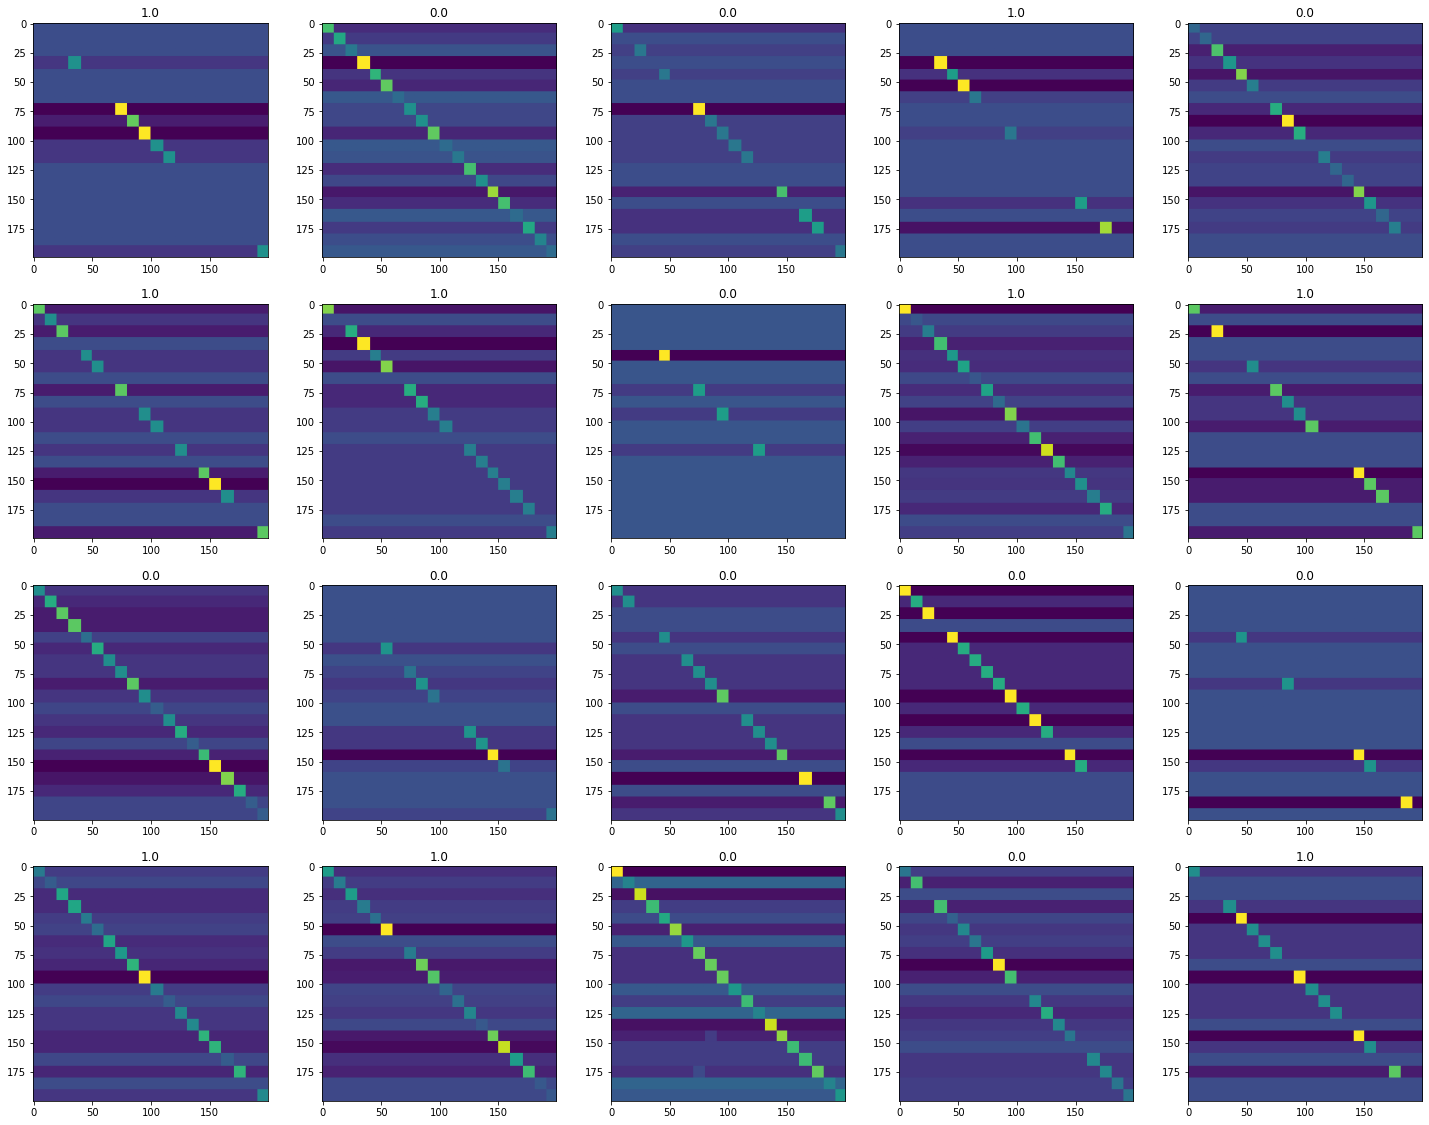

In [7]:
# Quick look at the some resulting images
plt.gcf().set_size_inches(25, 25)
for x_batch, y_batch in train_data:
    for i in range(0, 20):
        plt.subplot(5, 5, i+1)
        plt.title(y_batch[i])
        plt.imshow(x_batch[i])
    break

In [5]:
### model 1 
def create_Modelbaseline_images():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), input_shape=(200, 200, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3),  activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(1, (3, 3),  activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics= ['accuracy'])
    return model 
    #model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0

In [6]:
### model 2
# https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
def create_Modelbaseline_images():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(200, 200, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=5,strides=1,padding='same',activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.4))

    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))


    model.add(Flatten())
    model.add(Dense(1221, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.4))
    model.add(Dense(1221, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam',loss='binary_crossentropy', metrics= ['accuracy'])
    return model 
    #model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy']) 
model = create_Modelbaseline_images()    
print(model.summary())    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 198, 198, 32)      25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 196, 196, 64)      1

In [14]:
checkpoint = ModelCheckpoint("/mnt/vdb/thesis/CustomCNN.Adam.pssm.training2.set_9.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit_generator(
    generator=train_data,
    #steps_per_epoch = len(train_data) // 128,
    validation_data=validation_set,
    #validation_steps = len(validation_set) // 128, 
    epochs=100, 
    callbacks=[es,lr_scheduler]
)

Epoch 1/100
 40/443 [=>............................] - ETA: 8:20 - loss: 0.6516 - accuracy: 0.7557

KeyboardInterrupt: 

In [14]:
model.save("/mnt/vdb/thesis/CustomCNN.Adam.pssm.training2.set_9.h5")

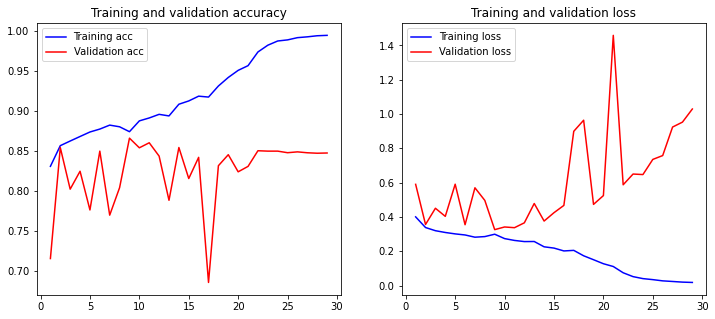

In [12]:
plot_history(history)

In [ ]:
# set 9
y_test = test_data.classes
y_probas = model.predict_generator(generator=test_data)
y_pred = np.where(y_probas > 0.5, 1, 0)
print(classification_report(y_test, y_pred)) 

In [ ]:
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)
plot_history(history)

In [13]:
# set 9
y_test = test_data.classes
y_probas = model.predict_generator(generator=test_data)
y_pred = np.where(y_probas > 0.5, 1, 0)
print(classification_report(y_test, y_pred)) 

Instructions for updating:
Please use Model.predict, which supports generators.
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1778
           1       0.84      0.78      0.81      1778

    accuracy                           0.82      3556
   macro avg       0.82      0.82      0.82      3556
weighted avg       0.82      0.82      0.82      3556



In [19]:
# set 1
y_test = test_data.classes
y_probas = model.predict_generator(generator=test_data)
y_pred = np.where(y_probas > 0.5, 1, 0)
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.57      0.92      0.70      1778
           1       0.79      0.31      0.45      1778

    accuracy                           0.62      3556
   macro avg       0.68      0.62      0.58      3556
weighted avg       0.68      0.62      0.58      3556



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
_precision = []
_recal = []
_f1 = []
_auc_pr = []
_roc_pr = []
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for x in range(5):
    
    datagen = ImageDataGenerator(validation_split=0.2 , rescale=1/255 )
    validation_datagen = ImageDataGenerator(validation_split = .2)

    train_data = datagen.flow_from_directory(directory='/mnt/vdb/thesis/trainingset2/set9/pssm/images/',
                                          class_mode='binary', batch_size=128, target_size=(200, 200),
                                          subset='training',shuffle= True)

    validation_set = datagen.flow_from_directory(directory='/mnt/vdb/thesis/trainingset2/set9/pssm/images/',
                                            class_mode='binary', batch_size=128,target_size=(200, 200),
                                            subset='validation',shuffle= True)

    test_data = datagen.flow_from_directory(directory='/mnt/vdb/thesis/trainingset2/benchmark_set/images/',
                                            class_mode='binary', batch_size=128,target_size=(200, 200),shuffle= False)

    model = create_Modelbaseline_images()
    # Early Stopping
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    #learning rate decay
    lr_scheduler = LearningRateScheduler(lr_schedule)
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
 
    history = model.fit_generator(
        generator=train_data,
        #steps_per_epoch = len(train_data) // 128,
        validation_data=validation_set,
        #validation_steps = len(validation_set) // 128, 
        epochs=100, 
        callbacks=[es,lr_scheduler], verbose=0
    )

    y_test = test_data.classes
    y_probas = model.predict_generator(generator=test_data)
    y_predict = np.where(y_probas > 0.5, 1, 0)
    print(classification_report(y_test, y_pred)) 

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_predict, y_test)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = (precision_score(y_predict,y_test, pos_label= 1)+precision_score(y_predict,y_test , pos_label= 0))*0.5
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = (recall_score(y_predict,y_test, pos_label= 1)+recall_score(y_predict,y_test , pos_label= 0))*0.5
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 =  (f1_score(y_predict,y_test, pos_label= 1)+f1_score(y_predict,y_test , pos_label= 0))*0.5
    print('F1 score: %f' % f1)
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])  
    _precision.append(precision * 100)  
    _recal.append(recall * 100)  
    _f1.append(f1 * 100)  
 
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Pecision: {np.mean(_precision)} (+- {np.std(_precision)})')
print(f'> Recall: {np.mean(_recal)} (+- {np.std(_recal)})')
print(f'> F1: {np.mean(_f1)} (+- {np.std(_f1)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Found 56612 images belonging to 2 classes.
Found 14152 images belonging to 2 classes.
Found 3556 images belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 1 ...
Instructions for updating:
Please use Model.fit, which supports generators.


In [31]:
# set 3
y_test = test_data.classes
y_probas = model.predict_generator(generator=test_data)
y_pred = np.where(y_probas > 0.8, 1, 0)
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      1778
           1       0.76      0.72      0.74      1778

    accuracy                           0.75      3556
   macro avg       0.75      0.75      0.75      3556
weighted avg       0.75      0.75      0.75      3556



In [38]:
# set 3
y_pred = np.where(y_probas > 0.5, 1, 0)
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.80      0.65      0.72      1778
           1       0.70      0.84      0.77      1778

    accuracy                           0.74      3556
   macro avg       0.75      0.74      0.74      3556
weighted avg       0.75      0.74      0.74      3556



# Conclusion

In [ ]:
# IF you AveragePooling in any -> didn;t show the good performance so use Maxpooling 
# 1211 , 512 show the better performance  

# 2 CNN layer
# 2 Dense layer 

# Add

In [19]:
model.layers_by_depth

AttributeError: 'Functional' object has no attribute 'layers_by_depth'